In [56]:
import numpy as np
import numpy.polynomial.polynomial as poly

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter

from urllib.request import urlopen
import json

import itertools

from time import time
from datetime import datetime, timedelta
from pytz import timezone

import altair as alt
# from vega_datasets import data

In [66]:
with open('data/county_json2.json') as f:
    county_json2 = json.load(f)
    
nyt_df = pd.read_csv('data/nyt_df.csv', dtype={'fips':'str'}, parse_dates=['date'])
nyt_df.head()

date     county       state   fips  cases  deaths
0 2020-01-21  Snohomish  Washington  53061      1       0
1 2020-01-22  Snohomish  Washington  53061      1       0
2 2020-01-23  Snohomish  Washington  53061      1       0
3 2020-01-24       Cook    Illinois  17031      1       0
4 2020-01-24  Snohomish  Washington  53061      1       0

In [67]:
nyt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360123 entries, 0 to 360122
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    360123 non-null  datetime64[ns]
 1   county  360123 non-null  object        
 2   state   360123 non-null  object        
 3   fips    360123 non-null  object        
 4   cases   360123 non-null  int64         
 5   deaths  360123 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 16.5+ MB


In [68]:
pop_df_ac = pd.read_csv('data/pop_df_ac.csv', dtype={'fips':'str', 'cluster':'int'})
pop_df_ac.head()

state   county  total_pop   fips   white  black  asian  hispanic  \
0  Alabama  Autauga      55869  01001   41215  11098    646      1671   
1  Alabama  Baldwin     223234  01003  185747  19215   2346     10534   
2  Alabama  Barbour      24686  01005   11235  11807    116      1117   
3  Alabama     Bibb      22394  01007   16663   4719     46       623   
4  Alabama   Blount      57826  01009   50176    872    163      5582   

       area        lon  ...  total_votes  median_income  pop_density  \
0   594.436 -86.641196  ...      24661.0          58786    93.986569   
1  1589.784 -87.723954  ...      94090.0          55962   140.417818   
2   884.876 -85.389245  ...      10390.0          34186    27.897694   
3   622.582 -87.124963  ...       8748.0          45340    35.969559   
4   644.776 -86.569756  ...      25384.0          48695    89.683859   

   per_white  per_black  per_asian  per_hispanic  per_votes_gop  \
0   0.737708   0.198643   0.011563      0.029909       0.324151   
1   0.832073   0.086076   0.010509      0.047188       0.326026   
2   0.455116   0.478287   0.004699      0.045248       0.220003   
3   0.744083   0.210726   0.002054      0.027820       0.300661   
4   0.867707   0.015080   0.002819      0.096531       0.394425   

   per_votes_dem  cluster  
0       0.105747        1  
1       0.082465        7  
2       0.196387        0  
3       0.083683        1  
4       0.037181        3  

[5 rows x 24 columns]

In [70]:
df = nyt_df.merge(pop_df_ac[['fips', 'cluster', 'state', 'county']], on='fips', suffixes=('_x',''))
df = df.drop(['county_x', 'state_x'], axis=1)
# df['cluster'] = df['cluster'].astype(int)
# # person density
# df[['cases_per_100k', 'deaths_per_100k']] = df[['cases', 'deaths']].div(df['tot_pop'], axis=0) * 100_000
# df = df.drop('tot_pop', axis=1)

df = df.sort_values(by=['date', 'fips'])

print(df.shape)
df.head()

(353573, 7)


date   fips  cases  deaths  cluster       state     county
0   2020-01-21  53061      1       0        4  Washington  Snohomish
1   2020-01-22  53061      1       0        4  Washington  Snohomish
2   2020-01-23  53061      1       0        4  Washington  Snohomish
185 2020-01-24  17031      1       0       11    Illinois       Cook
3   2020-01-24  53061      1       0        4  Washington  Snohomish

In [71]:
clustered = df.groupby(by=['state', 'cluster', 'date'])
wm_pop = lambda x: np.average(x, weights=df.loc[x.index, 'total_pop'])
wm_area = lambda x: np.average(x, weights=df.loc[x.index, 'area'])

df_ac0 = clustered.agg(
    cases=('cases', sum),
    deaths=('deaths', sum),
#     county=('county', '-'.join),
#     total_pop=('total_pop', sum),
#     fips=('fips', '-'.join),
#     white=('white', sum),
#     black=('black', sum),
#     asian=('asian', sum),
#     hispanic=('hispanic', sum),
#     area=('area', sum),
#     lon=('lon', wm_area),
#     lat=('lat', wm_area),
#     votes_gop=('votes_gop', sum),
#     votes_dem=('votes_dem', sum),
#     total_votes=('total_votes', sum),
#     median_income=('median_income', wm_pop)
).reset_index()

df_ac0.head()

state  cluster       date  cases  deaths
0  Alabama        0 2020-03-19      1       0
1  Alabama        0 2020-03-20      1       0
2  Alabama        0 2020-03-21      1       0
3  Alabama        0 2020-03-22      2       0
4  Alabama        0 2020-03-23      3       0

In [72]:
pop_df_ac.columns

Index(['state', 'county', 'total_pop', 'fips', 'white', 'black', 'asian',
       'hispanic', 'area', 'lon', 'lat', 'pop_per_area', 'votes_gop',
       'votes_dem', 'total_votes', 'median_income', 'pop_density', 'per_white',
       'per_black', 'per_asian', 'per_hispanic', 'per_votes_gop',
       'per_votes_dem', 'cluster'],
      dtype='object')

In [107]:
clustered = pop_df_ac.groupby(by=['state', 'cluster'])
wm_pop = lambda x: np.average(x, weights=pop_df_ac.loc[x.index, 'total_pop'])
wm_area = lambda x: np.average(x, weights=pop_df_ac.loc[x.index, 'area'])

pop_df_ac = clustered.agg(
    county=('county', '-'.join),
    total_pop=('total_pop', sum),
    fips=('fips', '-'.join),
    white=('white', sum),
    black=('black', sum),
    asian=('asian', sum),
    hispanic=('hispanic', sum),
    area=('area', sum),
    lon=('lon', wm_area),
    lat=('lat', wm_area),
    votes_gop=('votes_gop', sum),
    votes_dem=('votes_dem', sum),
    total_votes=('total_votes', sum),
    median_income=('median_income', wm_pop)
).reset_index()

pop_df_ac['pop_density'] = pop_df_ac['total_pop'] / pop_df_ac['area']

cols = ['white', 'black', 'asian', 'hispanic', 'total_votes']
for col in cols:
    pop_df_ac['per_' + col] = pop_df_ac[col] / pop_df_ac['total_pop']
    
cols2 = ['votes_gop', 'votes_dem']
for col in cols2:
    pop_df_ac['per_' + col] = pop_df_ac[col] / pop_df_ac['total_votes']

pop_df_ac.head()

state  cluster                                             county  \
0  Alabama        0  Barbour-Butler-Chambers-Coffee-Conecuh-Covingt...   
1  Alabama        1  Autauga-Bibb-Calhoun-Cherokee-Chilton-Clay-Cle...   
2  Alabama        2          Bullock-Dallas-Lowndes-Macon-Perry-Wilcox   
3  Alabama        3  Blount-Colbert-Cullman-Fayette-Franklin-Lamar-...   
4  Alabama        4  Choctaw-Clarke-Greene-Hale-Marengo-Pickens-Sum...   

   total_pop                                               fips    white  \
0     539589  01005-01013-01017-01031-01035-01039-01041-0104...   338024   
1    1373565  01001-01007-01015-01019-01021-01027-01029-0103...  1053151   
2      94387                01011-01047-01085-01087-01105-01131    22956   
3     500816  01009-01033-01043-01057-01059-01075-01077-0107...   428659   
4     319548    01023-01025-01063-01065-01091-01107-01119-01125   176087   

    black  asian  hispanic       area  ...  total_votes  median_income  \
0  159525   5135     21863  10987.781  ...     219861.0   41719.812163   
1  195753  13429     80569  13048.657  ...     578473.0   51895.248660   
2   67855    389      2110   4534.458  ...      50205.0   30432.096984   
3   33082   2537     24020   7343.401  ...     220216.0   43456.648436   
4  124442   3842     10815   7526.950  ...     141617.0   45385.662126   

   pop_density  per_white  per_black  per_asian  per_hispanic  \
0    49.108096   0.626447   0.295642   0.009517      0.040518   
1   105.264856   0.766728   0.142515   0.009777      0.058657   
2    20.815498   0.243211   0.718902   0.004121      0.022355   
3    68.199462   0.855921   0.066056   0.005066      0.047962   
4    42.453849   0.551050   0.389431   0.012023      0.033845   

   per_total_votes  per_votes_gop  per_votes_dem  
0         0.407460       0.673130       0.309373  
1         0.421147       0.752253       0.222752  
2         0.531906       0.263081       0.729549  
3         0.439714       0.805677       0.172753  
4         0.443179       0.530876       0.449543  

[5 rows x 24 columns]

In [108]:
df_ac = df_ac0.merge(pop_df_ac, on=['state', 'cluster'], suffixes=('_x',''))
# df_ac = df_ac.drop(['county_x', 'fips_x'], axis=1)

# # person density
# df[['cases_per_100k', 'deaths_per_100k']] = df[['cases', 'deaths']].div(df['tot_pop'], axis=0) * 100_000
# df = df.drop('tot_pop', axis=1)

df_ac = df_ac.sort_values(by=['date', 'fips'])

print(df_ac.shape)
df_ac.head()

(74503, 27)


state  cluster       date  cases  deaths  \
70866  Washington        4 2020-01-21      1       0   
70867  Washington        4 2020-01-22      1       0   
70868  Washington        4 2020-01-23      1       0   
22987    Illinois       11 2020-01-24      1       0   
70869  Washington        4 2020-01-24      1       0   

                                 county  total_pop                     fips  \
70866  Island-Kitsap-Snohomish-Thurston    1469233  53029-53035-53061-53067   
70867  Island-Kitsap-Snohomish-Thurston    1469233  53029-53035-53061-53067   
70868  Island-Kitsap-Snohomish-Thurston    1469233  53029-53035-53061-53067   
22987                              Cook    5150233                    17031   
70869  Island-Kitsap-Snohomish-Thurston    1469233  53029-53035-53061-53067   

         white    black  ...  total_votes  median_income  pop_density  \
70866  1048126    48691  ...     592847.0   77050.580979   430.528825   
70867  1048126    48691  ...     592847.0   77050.580979   430.528825   
70868  1048126    48691  ...     592847.0   77050.580979   430.528825   
22987  2162156  1184247  ...    2055215.0   62088.000000  5448.102559   
70869  1048126    48691  ...     592847.0   77050.580979   430.528825   

       per_white  per_black  per_asian  per_hispanic  per_total_votes  \
70866   0.713383    0.03314   0.090637      0.097824         0.403508   
70867   0.713383    0.03314   0.090637      0.097824         0.403508   
70868   0.713383    0.03314   0.090637      0.097824         0.403508   
22987   0.419817    0.22994   0.077317      0.256160         0.399053   
70869   0.713383    0.03314   0.090637      0.097824         0.403508   

       per_votes_gop  per_votes_dem  
70866       0.384033       0.530128  
70867       0.384033       0.530128  
70868       0.384033       0.530128  
22987       0.214193       0.743758  
70869       0.384033       0.530128  

[5 rows x 27 columns]

In [109]:
df_ac[['cases_per_100k', 'deaths_per_100k']] = df_ac[['cases', 'deaths']].div(df_ac['total_pop'], axis=0) * 100_000

In [110]:
df_ac.to_csv('data/df_ac-no-trends.csv', index=False)

In [111]:
cols = ['cases', 'deaths', 'cases_per_100k', 'deaths_per_100k']

def add_change_cols(df, cols, pre='new_', clip=True):
    df = df.sort_values(by=['date', 'fips'])
    new_cols = [pre + c for c in cols]
    df[new_cols] = df[cols] - df.groupby(by='fips')[cols].shift()
    df[new_cols] = df[new_cols].fillna(0)
    if clip:
        df[new_cols] = df[new_cols].clip(lower=0)
    return (df, new_cols)

def add_savgol_cols(df, cols, window=7):
    def my_savgol(x, w):
        if len(x) >= w:
            return savgol_filter(x, w, 1)
        else:
            new_window = int(np.ceil(len(x) / 2) * 2 - 1)
            if new_window <= 1:
                return x
            else:
                return savgol_filter(x, new_window, 1)
    df = df.sort_values(by=['date', 'fips'])
    cols_d = [c + '_' + str(window) + 'sg' for c in cols]
    df[cols_d] = df.groupby(by='fips')[cols].transform(lambda x: my_savgol(x, window))
    return (df, cols_d)

In [112]:
ding = time()
df_ac, new_cols = add_change_cols(df_ac, cols, pre='new_', clip=True)
df_ac, new_cols_7sg = add_savgol_cols(df_ac, new_cols)
df_ac, new_cols_15sg = add_savgol_cols(df_ac, new_cols, window=15)
df_ac, delta_new_cols = add_change_cols(df_ac, new_cols, pre='delta_', clip=False)
df_ac, delta_new_cols_7sg = add_savgol_cols(df_ac, delta_new_cols)
df_ac, delta_new_cols_15sg = add_savgol_cols(df_ac, delta_new_cols, window=15)
dong = time()
print(dong - ding)
print(df_ac.columns)
df_ac.head()

6.075786590576172
Index(['state', 'cluster', 'date', 'cases', 'deaths', 'county', 'total_pop',
       'fips', 'white', 'black', 'asian', 'hispanic', 'area', 'lon', 'lat',
       'votes_gop', 'votes_dem', 'total_votes', 'median_income', 'pop_density',
       'per_white', 'per_black', 'per_asian', 'per_hispanic',
       'per_total_votes', 'per_votes_gop', 'per_votes_dem', 'cases_per_100k',
       'deaths_per_100k', 'new_cases', 'new_deaths', 'new_cases_per_100k',
       'new_deaths_per_100k', 'new_cases_7sg', 'new_deaths_7sg',
       'new_cases_per_100k_7sg', 'new_deaths_per_100k_7sg', 'new_cases_15sg',
       'new_deaths_15sg', 'new_cases_per_100k_15sg',
       'new_deaths_per_100k_15sg', 'delta_new_cases', 'delta_new_deaths',
       'delta_new_cases_per_100k', 'delta_new_deaths_per_100k',
       'delta_new_cases_7sg', 'delta_new_deaths_7sg',
       'delta_new_cases_per_100k_7sg', 'delta_new_deaths_per_100k_7sg',
       'delta_new_cases_15sg', 'delta_new_deaths_15sg',
       'delta_new_

state  cluster       date  cases  deaths  \
70866  Washington        4 2020-01-21      1       0   
70867  Washington        4 2020-01-22      1       0   
70868  Washington        4 2020-01-23      1       0   
22987    Illinois       11 2020-01-24      1       0   
70869  Washington        4 2020-01-24      1       0   

                                 county  total_pop                     fips  \
70866  Island-Kitsap-Snohomish-Thurston    1469233  53029-53035-53061-53067   
70867  Island-Kitsap-Snohomish-Thurston    1469233  53029-53035-53061-53067   
70868  Island-Kitsap-Snohomish-Thurston    1469233  53029-53035-53061-53067   
22987                              Cook    5150233                    17031   
70869  Island-Kitsap-Snohomish-Thurston    1469233  53029-53035-53061-53067   

         white    black  ...  delta_new_cases_per_100k  \
70866  1048126    48691  ...                       0.0   
70867  1048126    48691  ...                       0.0   
70868  1048126    48691  ...                       0.0   
22987  2162156  1184247  ...                       0.0   
70869  1048126    48691  ...                       0.0   

       delta_new_deaths_per_100k  delta_new_cases_7sg  delta_new_deaths_7sg  \
70866                        0.0             0.000000                   0.0   
70867                        0.0             0.000000                   0.0   
70868                        0.0             0.000000                   0.0   
22987                        0.0            -0.178571                   0.0   
70869                        0.0             0.000000                   0.0   

       delta_new_cases_per_100k_7sg  delta_new_deaths_per_100k_7sg  \
70866                      0.000000                            0.0   
70867                      0.000000                            0.0   
70868                      0.000000                            0.0   
22987                     -0.003467                            0.0   
70869                      0.000000                            0.0   

       delta_new_cases_15sg  delta_new_deaths_15sg  \
70866                 0.000                    0.0   
70867                 0.000                    0.0   
70868                 0.000                    0.0   
22987                 0.025                    0.0   
70869                 0.000                    0.0   

       delta_new_cases_per_100k_15sg  delta_new_deaths_per_100k_15sg  
70866                       0.000000                             0.0  
70867                       0.000000                             0.0  
70868                       0.000000                             0.0  
22987                       0.000485                             0.0  
70869                       0.000000                             0.0  

[5 rows x 53 columns]

In [80]:
df_ac.to_csv('data/df_ac.csv', index=False)

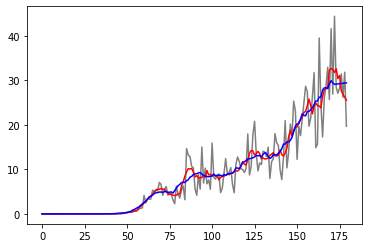

In [81]:
county = 'Los Angeles'
temp_df = df_ac[df_ac['county'] == county]
plt.plot(np.arange(len(temp_df)), 'new_cases_per_100k', data=temp_df, color='gray')
plt.plot(np.arange(len(temp_df)), 'new_cases_per_100k_7sg', data=temp_df, color='red')
plt.plot(np.arange(len(temp_df)), 'new_cases_per_100k_15sg', data=temp_df, color='blue')

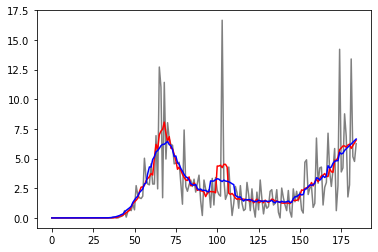

In [82]:
county = 'Island-Kitsap-Snohomish-Thurston'
temp_df = df_ac[df_ac['county'] == county]
plt.plot(np.arange(len(temp_df)), 'new_cases_per_100k', data=temp_df, color='gray')
plt.plot(np.arange(len(temp_df)), 'new_cases_per_100k_7sg', data=temp_df, color='red')
plt.plot(np.arange(len(temp_df)), 'new_cases_per_100k_15sg', data=temp_df, color='blue')

In [83]:
df_ac['days'] = ((df_ac['date'] - df_ac['date'].min()) / np.timedelta64(1, 'D')).astype('int')

In [123]:
la = timezone('US/Pacific')
last = df_ac['date'].max()
df_slice = df_ac[df_ac['date'] == last]
df_slice['gop'] = (df_slice['votes_gop'] > df_slice['votes_dem'])
df_slice.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


state  cluster       date  cases  deaths  \
259   Alabama        1 2020-07-23  18916     280   
1038  Alabama        7 2020-07-23   2710      26   
126   Alabama        0 2020-07-23   8538     160   
507   Alabama        3 2020-07-23   6884     135   
380   Alabama        2 2020-07-23   3197      81   

                                                 county  total_pop  \
259   Autauga-Bibb-Calhoun-Cherokee-Chilton-Clay-Cle...    1373565   
1038                                 Baldwin-Washington     239560   
126   Barbour-Butler-Chambers-Coffee-Conecuh-Covingt...     539589   
507   Blount-Colbert-Cullman-Fayette-Franklin-Lamar-...     500816   
380           Bullock-Dallas-Lowndes-Macon-Perry-Wilcox      94387   

                                                   fips    white   black  ...  \
259   01001-01007-01015-01019-01021-01027-01029-0103...  1053151  195753  ...   
1038                                        01003-01129   196353   22992  ...   
126   01005-01013-01017-01031-01035-01039-01041-0104...   338024  159525  ...   
507   01009-01033-01043-01057-01059-01075-01077-0107...   428659   33082  ...   
380                 01011-01047-01085-01087-01105-01131    22956   67855  ...   

      delta_new_deaths_per_100k  delta_new_cases_7sg  delta_new_deaths_7sg  \
259                   -0.436820            55.428571              0.178571   
1038                   0.417432            75.071429              0.428571   
126                   -0.741305            38.500000              0.464286   
507                   -1.996741            13.035714             -1.464286   
380                   -3.178404            -0.178571              0.500000   

      delta_new_cases_per_100k_7sg  delta_new_deaths_per_100k_7sg  \
259                       4.035380                       0.013001   
1038                     31.337213                       0.178899   
126                       7.135060                       0.086044   
507                       2.602895                      -0.292380   
380                      -0.189191                       0.529734   

      delta_new_cases_15sg  delta_new_deaths_15sg  \
259               9.150000               0.375000   
1038             42.066667               0.016667   
126              17.958333               0.516667   
507              -0.741667              -1.050000   
380              -4.516667               0.433333   

      delta_new_cases_per_100k_15sg  delta_new_deaths_per_100k_15sg    gop  
259                        0.666150                        0.027301   True  
1038                      17.559971                        0.006957   True  
126                        3.328150                        0.095752   True  
507                       -0.148092                       -0.209658   True  
380                       -4.785264                        0.459103  False  

[5 rows x 54 columns]

In [85]:
# https://stackoverflow.com/a/55950538
county_json_alt = alt.InlineData(county_json2, format=alt.DataFormat(property='features',type='json'))

In [113]:
def cov(x, y, w):
    return np.sum(w * (x - np.average(x, weights=w)) * (y - np.average(x, weights=w))) / np.sum(w)

def corr(x, y, w):
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))

In [137]:
df_slice.columns

Index(['state', 'cluster', 'date', 'cases', 'deaths', 'county', 'total_pop',
       'fips', 'white', 'black', 'asian', 'hispanic', 'area', 'lon', 'lat',
       'votes_gop', 'votes_dem', 'total_votes', 'median_income', 'pop_density',
       'per_white', 'per_black', 'per_asian', 'per_hispanic',
       'per_total_votes', 'per_votes_gop', 'per_votes_dem', 'cases_per_100k',
       'deaths_per_100k', 'new_cases', 'new_deaths', 'new_cases_per_100k',
       'new_deaths_per_100k', 'new_cases_7sg', 'new_deaths_7sg',
       'new_cases_per_100k_7sg', 'new_deaths_per_100k_7sg', 'new_cases_15sg',
       'new_deaths_15sg', 'new_cases_per_100k_15sg',
       'new_deaths_per_100k_15sg', 'delta_new_cases', 'delta_new_deaths',
       'delta_new_cases_per_100k', 'delta_new_deaths_per_100k',
       'delta_new_cases_7sg', 'delta_new_deaths_7sg',
       'delta_new_cases_per_100k_7sg', 'delta_new_deaths_per_100k_7sg',
       'delta_new_cases_15sg', 'delta_new_deaths_15sg',
       'delta_new_cases_per_100k_15s

In [143]:
pop_df_ac['gop'] = (pop_df_ac['votes_gop'] > pop_df_ac['votes_dem'])
pop_df_ac.groupby(by='gop')['fips'].count()

gop
False    200
True     379
Name: fips, dtype: int64

In [142]:
pop_df = pd.read_csv('data/pop_df.csv', dtype={'fips':'str'})
pop_df['gop'] = (pop_df['votes_gop'] > pop_df['votes_dem'])
pop_df.groupby(by='gop')['fips'].count()

gop
False     506
True     2639
Name: fips, dtype: int64

In [ ]:
df_slice2.groupby(by='gop')['fips'].count()

In [115]:
x_cols = ['pop_density', 'per_white', 'per_black', 'per_asian', 'per_hispanic', 'per_total_votes', 'per_votes_gop', 'median_income']
y_cols = ['pop_density', 'per_white', 'per_black', 'per_asian', 'per_hispanic', 'per_total_votes', 'per_votes_gop', 'median_income', 'cases_per_100k', 'deaths_per_100k', 'new_cases_per_100k_15sg', 'new_deaths_per_100k_15sg', 'delta_new_cases_per_100k_15sg', 'delta_new_deaths_per_100k_15sg']
w_col = 'total_pop'

Text(0.5, 0.98, 'covid correlation heatmap')

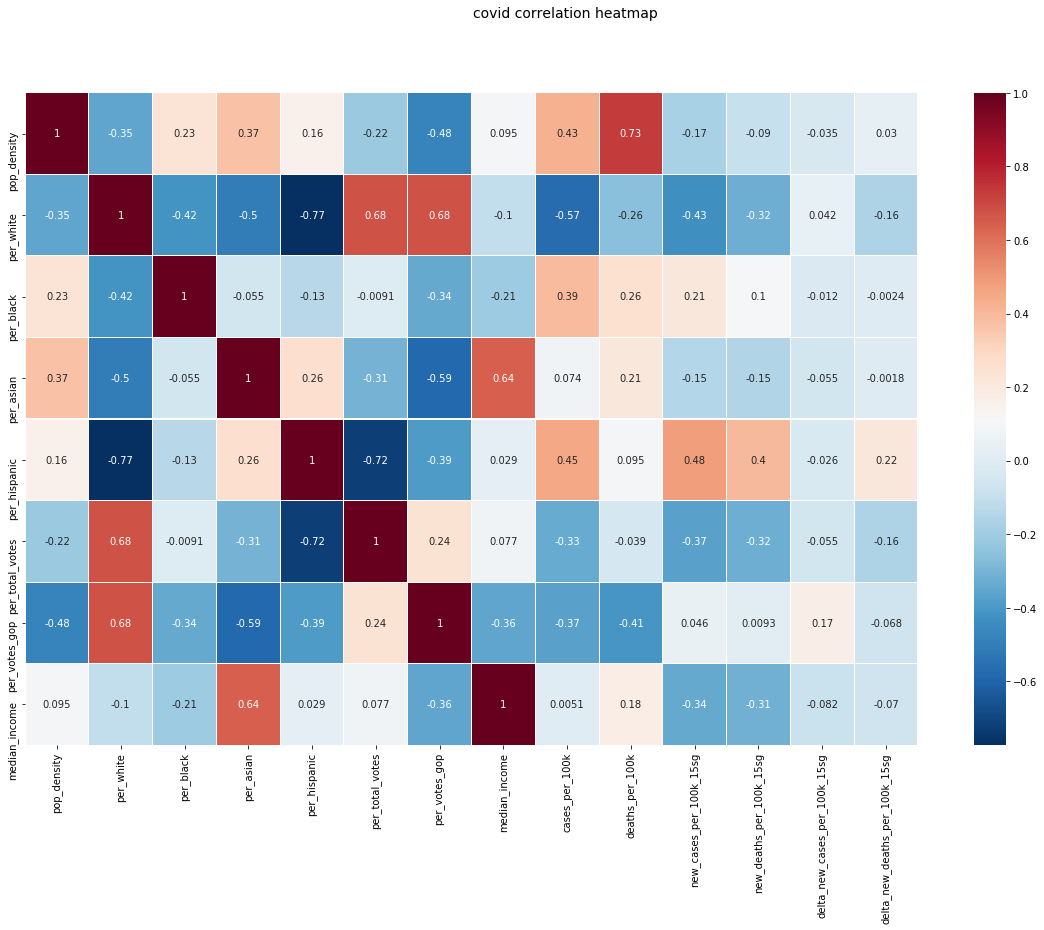

In [119]:
wcm = pd.DataFrame(index=x_cols, columns=y_cols)

for x in x_cols:
    for y in y_cols:
        wcm.loc[x, y] = corr(df_slice[x], df_slice[y], df_slice[w_col])
        
fig, (ax) = plt.subplots(1, 1, figsize=(20,12))

hm = sns.heatmap(np.array(wcm,dtype='float64'), 
                 ax=ax,
                 yticklabels=wcm.index,
                 xticklabels=wcm.columns,
                 cmap="RdBu_r",
                 annot=True, 
#                  fmt='.1f',
                 linewidths=.05)

# fig.subplots_adjust(top=0.93)
fig.suptitle('covid correlation heatmap', 
              fontsize=14)

In [100]:
chart_title='Case Density vs. Population Density'
x_col='pop_density'
x_scale='sqrt'
x_title='pop per sq mi'
y_col='cases_per_100k'
y_scale='sqrt'
y_title='cases per 100k'
s_col='cases'
s_title='total cases'
c_col='new_cases_per_100k_15sg'
c_title='new cases per 100k (15d window)'
c_scheme='lightmulti'
w_col='total_pop'
split=False
line=True

data = df_slice.sort_values(by=c_col).copy()

smax = np.max(data[s_col])
smax = smax + (-smax) % 10

chart = alt.Chart(data).mark_circle(
    stroke='black',
    strokeWidth=0.25,
).properties(
    title=chart_title,
    width=720,
    height=480
).encode(
    x=alt.X(
        x_col + ':Q',
        scale=alt.Scale(type=x_scale),
        title=x_title
    ),
    y=alt.Y(
        y_col + ':Q',
        scale=alt.Scale(type=y_scale),
        title=y_title
    ),
    size=alt.Size(
        s_col + ':Q',
        scale=alt.Scale(
            domain=[1,smax],
            range=[10,2000]
        ),
        title=s_title
    ),
    color=alt.Color(
        c_col + ':Q',
        scale=alt.Scale(
            scheme=c_scheme,
            domain=[np.percentile(data[c_col], 1), np.percentile(data[c_col], 99)],
#             domainMid=params['c_mid'],
        ),
        sort='ascending',
        title=c_title
    ),
    tooltip=[
        'state:N', 'county:N',
        alt.Tooltip(
            'cases:Q',
            title='total cases',
        ), 
        alt.Tooltip(
            'cases_per_100k:Q',
            format='.1f',
            title='cases per 100k',
        ), 
        alt.Tooltip(
            'pop_per_area:Q',
            format='.1f',
            title='pop per sq mi',
        ), 
        alt.Tooltip(
            y_col + ':Q',
            format='.1f',
            title=y_title
        ),
        alt.Tooltip(
            x_col + ':Q',
            format='.1f',
            title=x_title
        )
    ]
)

chart

alt.Chart(...)

In [104]:
chart_title='Case Density vs. Median Income'
x_col='median_income'
x_scale='linear'
x_title='median income'
y_col='cases_per_100k'
y_scale='sqrt'
y_title='cases per 100k'
s_col='cases'
s_title='total cases'
c_col='new_cases_per_100k_15sg'
c_title='new cases per 100k (15d window)'
c_scheme='lightmulti'
w_col='total_pop'
split=False
line=True

data = df_slice.sort_values(by=c_col).copy()

smax = np.max(data[s_col])
smax = smax + (-smax) % 10

chart = alt.Chart(data).mark_circle(
    stroke='black',
    strokeWidth=0.25,
).properties(
    title=chart_title,
    width=720,
    height=480
).encode(
    x=alt.X(
        x_col + ':Q',
        scale=alt.Scale(type=x_scale),
        title=x_title
    ),
    y=alt.Y(
        y_col + ':Q',
        scale=alt.Scale(type=y_scale),
        title=y_title
    ),
    size=alt.Size(
        s_col + ':Q',
        scale=alt.Scale(
            domain=[1,smax],
            range=[10,2000]
        ),
        title=s_title
    ),
    color=alt.Color(
        c_col + ':Q',
        scale=alt.Scale(
            scheme=c_scheme,
            domain=[np.percentile(data[c_col], 1), np.percentile(data[c_col], 99)],
#             domainMid=params['c_mid'],
        ),
        sort='ascending',
        title=c_title
    ),
    tooltip=[
        'state:N', 'county:N',
        alt.Tooltip(
            'cases:Q',
            title='total cases',
        ), 
        alt.Tooltip(
            'cases_per_100k:Q',
            format='.1f',
            title='cases per 100k',
        ), 
        alt.Tooltip(
            'pop_density:Q',
            format='.1f',
            title='pop per sq mi',
        ), 
        alt.Tooltip(
            y_col + ':Q',
            format='.1f',
            title=y_title
        ),
        alt.Tooltip(
            x_col + ':Q',
            format='.1f',
            title=x_title
        )
    ]
)

chart

alt.Chart(...)

In [121]:
chart_title='New Case Density vs. Population Density'
x_col='pop_density'
x_scale='sqrt'
x_title='population density'
y_col='new_cases_per_100k_15sg'
y_scale='sqrt'
y_title='new cases per 100k'
s_col='cases'
s_title='total cases'
c_col='per_votes_gop'
c_title='% votes GOP'
c_scheme='redblue'
w_col='total_pop'
split=False
line=True

data = df_slice.sort_values(by=c_col).copy()

smax = np.max(data[s_col])
smax = smax + (-smax) % 10

chart = alt.Chart(data).mark_circle(
    stroke='black',
    strokeWidth=0.25,
).properties(
    title=chart_title,
    width=720,
    height=480
).encode(
    x=alt.X(
        x_col + ':Q',
        scale=alt.Scale(type=x_scale),
        title=x_title
    ),
    y=alt.Y(
        y_col + ':Q',
        scale=alt.Scale(type=y_scale),
        title=y_title
    ),
    size=alt.Size(
        s_col + ':Q',
        scale=alt.Scale(
            domain=[1,smax],
            range=[10,2000]
        ),
        title=s_title
    ),
    color=alt.Color(
        c_col + ':Q',
        scale=alt.Scale(
            scheme=c_scheme,
#             domain=[np.percentile(data[c_col], 1), np.percentile(data[c_col], 99)],
            domainMid=0.5,
        ),
        sort='descending',
        title=c_title
    ),
    tooltip=[
        'state:N', 'county:N',
        alt.Tooltip(
            'cases:Q',
            title='total cases',
        ), 
        alt.Tooltip(
            'cases_per_100k:Q',
            format='.1f',
            title='cases per 100k',
        ), 
        alt.Tooltip(
            'pop_density:Q',
            format='.1f',
            title='pop per sq mi',
        ), 
        alt.Tooltip(
            y_col + ':Q',
            format='.1f',
            title=y_title
        ),
        alt.Tooltip(
            x_col + ':Q',
            format='.1f',
            title=x_title
        )
    ]
)

chart

alt.Chart(...)

In [125]:
chart_title='New Case Density vs. Population Density'
x_col='per_votes_gop'
x_scale='linear'
x_title='% votes GOP'
y_col='new_cases_per_100k_15sg'
y_scale='sqrt'
y_title='new cases per 100k'
s_col='cases'
s_title='total cases'
c_col='per_votes_gop'
c_title='% votes GOP'
c_scheme='redblue'
w_col='total_pop'
split=False
line=True

data = df_slice.sort_values(by=c_col).copy()

smax = np.max(data[s_col])
smax = smax + (-smax) % 10

chart = alt.Chart(data).mark_circle(
    stroke='black',
    strokeWidth=0.25,
).properties(
    title=chart_title,
    width=720,
    height=480
).encode(
    x=alt.X(
        x_col + ':Q',
        scale=alt.Scale(type=x_scale),
        title=x_title
    ),
    y=alt.Y(
        y_col + ':Q',
        scale=alt.Scale(type=y_scale),
        title=y_title
    ),
    size=alt.Size(
        s_col + ':Q',
        scale=alt.Scale(
            domain=[1,smax],
            range=[10,2000]
        ),
        title=s_title
    ),
    color=alt.Color(
        c_col + ':Q',
        scale=alt.Scale(
            scheme=c_scheme,
#             domain=[np.percentile(data[c_col], 1), np.percentile(data[c_col], 99)],
            domainMid=0.5,
        ),
        sort='descending',
        title=c_title
    ),
    tooltip=[
        'state:N', 'county:N',
        alt.Tooltip(
            'cases:Q',
            title='total cases',
        ), 
        alt.Tooltip(
            'cases_per_100k:Q',
            format='.1f',
            title='cases per 100k',
        ), 
        alt.Tooltip(
            'pop_density:Q',
            format='.1f',
            title='pop per sq mi',
        ), 
        alt.Tooltip(
            y_col + ':Q',
            format='.1f',
            title=y_title
        ),
        alt.Tooltip(
            x_col + ':Q',
            format='.1f',
            title=x_title
        )
    ]
)

pfit0 = poly.polyfit(data[data['gop']==0][x_col], data[data['gop']==0][y_col], 1, w=data[data['gop']==0][w_col])
pfit1 = poly.polyfit(data[data['gop']==1][x_col], data[data['gop']==1][y_col], 1, w=data[data['gop']==1][w_col])
fit0 = poly.polyval(np.unique(data[data['gop']==0][x_col]), pfit0)
fit1 = poly.polyval(np.unique(data[data['gop']==1][x_col]), pfit1)
line_df0 = pd.DataFrame({
  'x': np.unique(data[data['gop']==0][x_col]),
  'y': fit0
})
line_df1 = pd.DataFrame({
  'x': np.unique(data[data['gop']==1][x_col]),
  'y': fit1
})
line0 = alt.Chart(line_df0).mark_line(color='darkblue').encode(
    x='x:Q',
    y='y:Q'
).transform_calculate(label='datum.y + "inches"')
line1 = alt.Chart(line_df1).mark_line(color='firebrick').encode(
    x='x:Q',
    y='y:Q'
)


chart + line0 + line1

alt.LayerChart(...)

In [131]:
chart_title='Case Density vs. Population Density'
x_col='per_votes_gop'
x_scale='linear'
x_title='% votes GOP'
y_col='cases_per_100k'
y_scale='sqrt'
y_title='cases per 100k'
s_col='cases'
s_title='total cases'
c_col='per_votes_gop'
c_title='% votes GOP'
c_scheme='redblue'
w_col='total_pop'
split=False
line=True

data = df_slice.sort_values(by=c_col).copy()

smax = np.max(data[s_col])
smax = smax + (-smax) % 10

chart = alt.Chart(data).mark_circle(
    stroke='black',
    strokeWidth=0.25,
).properties(
    title=chart_title,
    width=720,
    height=480
).encode(
    x=alt.X(
        x_col + ':Q',
        scale=alt.Scale(type=x_scale),
        title=x_title
    ),
    y=alt.Y(
        y_col + ':Q',
        scale=alt.Scale(type=y_scale),
        title=y_title
    ),
    size=alt.Size(
        s_col + ':Q',
        scale=alt.Scale(
            domain=[1,smax],
            range=[10,2000]
        ),
        title=s_title
    ),
    color=alt.Color(
        c_col + ':Q',
        scale=alt.Scale(
            scheme=c_scheme,
#             domain=[np.percentile(data[c_col], 1), np.percentile(data[c_col], 99)],
            domainMid=0.5,
        ),
        sort='descending',
        title=c_title
    ),
    tooltip=[
        'state:N', 'county:N',
        alt.Tooltip(
            'cases:Q',
            title='total cases',
        ), 
        alt.Tooltip(
            'cases_per_100k:Q',
            format='.1f',
            title='cases per 100k',
        ), 
        alt.Tooltip(
            'pop_density:Q',
            format='.1f',
            title='pop per sq mi',
        ), 
        alt.Tooltip(
            y_col + ':Q',
            format='.1f',
            title=y_title
        ),
        alt.Tooltip(
            x_col + ':Q',
            format='.1f',
            title=x_title
        )
    ]
)

pfit0 = poly.polyfit(data[x_col], data[y_col], 1, w=data[w_col])

fit0 = poly.polyval(np.unique(data[x_col]), pfit0)

line_df0 = pd.DataFrame({
  'x': np.unique(data[x_col]),
  'y': fit0
})

line0 = alt.Chart(line_df0).mark_line(color='black').encode(
    x='x:Q',
    y='y:Q'
).transform_calculate()


chart + line0

alt.LayerChart(...)

In [130]:
chart_title='New Case Density vs. Population Density'
x_col='per_votes_gop'
x_scale='linear'
x_title='% votes GOP'
y_col='new_cases_per_100k_15sg'
y_scale='sqrt'
y_title='new cases per 100k'
s_col='cases'
s_title='total cases'
c_col='per_votes_gop'
c_title='% votes GOP'
c_scheme='redblue'
w_col='total_pop'
split=False
line=True

data = df_slice.sort_values(by=c_col).copy()

smax = np.max(data[s_col])
smax = smax + (-smax) % 10

chart = alt.Chart(data).mark_circle(
    stroke='black',
    strokeWidth=0.25,
).properties(
    title=chart_title,
    width=720,
    height=480
).encode(
    x=alt.X(
        x_col + ':Q',
        scale=alt.Scale(type=x_scale),
        title=x_title
    ),
    y=alt.Y(
        y_col + ':Q',
        scale=alt.Scale(type=y_scale),
        title=y_title
    ),
    size=alt.Size(
        s_col + ':Q',
        scale=alt.Scale(
            domain=[1,smax],
            range=[10,2000]
        ),
        title=s_title
    ),
    color=alt.Color(
        c_col + ':Q',
        scale=alt.Scale(
            scheme=c_scheme,
#             domain=[np.percentile(data[c_col], 1), np.percentile(data[c_col], 99)],
            domainMid=0.5,
        ),
        sort='descending',
        title=c_title
    ),
    tooltip=[
        'state:N', 'county:N',
        alt.Tooltip(
            'cases:Q',
            title='total cases',
        ), 
        alt.Tooltip(
            'cases_per_100k:Q',
            format='.1f',
            title='cases per 100k',
        ), 
        alt.Tooltip(
            'pop_density:Q',
            format='.1f',
            title='pop per sq mi',
        ), 
        alt.Tooltip(
            y_col + ':Q',
            format='.1f',
            title=y_title
        ),
        alt.Tooltip(
            x_col + ':Q',
            format='.1f',
            title=x_title
        )
    ]
)

pfit0 = poly.polyfit(data[x_col], data[y_col], 1, w=data[w_col])

fit0 = poly.polyval(np.unique(data[x_col]), pfit0)

line_df0 = pd.DataFrame({
  'x': np.unique(data[x_col]),
  'y': fit0
})

line0 = alt.Chart(line_df0).mark_line(color='black').encode(
    x='x:Q',
    y='y:Q'
).transform_calculate()


chart + line0

alt.LayerChart(...)

In [136]:
chart_title='Change in New Case Density vs. Population Density'
x_col='per_votes_gop'
x_scale='linear'
x_title='% votes GOP'
y_col='delta_new_cases_per_100k_15sg'
y_scale='sqrt'
y_title='cases per 100k'
s_col='cases'
s_title='total cases'
c_col='per_votes_gop'
c_title='% votes GOP'
c_scheme='redblue'
w_col='total_pop'
split=False
line=True

data = df_slice.sort_values(by=c_col).copy()

smax = np.max(data[s_col])
smax = smax + (-smax) % 10

chart = alt.Chart(data).mark_circle(
    stroke='black',
    strokeWidth=0.25,
).properties(
    title=chart_title,
    width=720,
    height=480
).encode(
    x=alt.X(
        x_col + ':Q',
        scale=alt.Scale(type=x_scale),
        title=x_title
    ),
    y=alt.Y(
        y_col + ':Q',
        scale=alt.Scale(type=y_scale),
        title=y_title
    ),
    size=alt.Size(
        s_col + ':Q',
        scale=alt.Scale(
            domain=[1,smax],
            range=[10,2000]
        ),
        title=s_title
    ),
    color=alt.Color(
        c_col + ':Q',
        scale=alt.Scale(
            scheme=c_scheme,
#             domain=[np.percentile(data[c_col], 1), np.percentile(data[c_col], 99)],
            domainMid=0.5,
        ),
        sort='descending',
        title=c_title
    ),
    tooltip=[
        'state:N', 'county:N',
        alt.Tooltip(
            'cases:Q',
            title='total cases',
        ), 
        alt.Tooltip(
            'cases_per_100k:Q',
            format='.1f',
            title='cases per 100k',
        ), 
        alt.Tooltip(
            'pop_density:Q',
            format='.1f',
            title='pop per sq mi',
        ), 
        alt.Tooltip(
            y_col + ':Q',
            format='.1f',
            title=y_title
        ),
        alt.Tooltip(
            x_col + ':Q',
            format='.1f',
            title=x_title
        )
    ]
)

pfit0 = poly.polyfit(data[x_col], data[y_col], 1, w=data[w_col])

fit0 = poly.polyval(np.unique(data[x_col]), pfit0)

line_df0 = pd.DataFrame({
  'x': np.unique(data[x_col]),
  'y': fit0
})

line0 = alt.Chart(line_df0).mark_line(color='black').encode(
    x='x:Q',
    y='y:Q'
).transform_calculate()


chart + line0

alt.LayerChart(...)